In [1]:
# Check GPU status
!nvidia-smi


Sat Nov  2 12:36:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P400                    Off | 00000000:2D:00.0  On |                  N/A |
| 34%   39C    P8              N/A /  N/A |    102MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

2024-11-02 12:36:12.640851: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 12:36:12.690036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 12:36:13.386204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Load graph
view=4
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/mayank/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [6]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1612030  Test:460580  Validation: 230290


In [13]:
# Model

model = DistMult(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer =  optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [14]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.9996
Epoch: 002, Loss: 0.9633
Epoch: 003, Loss: 0.8049
Epoch: 004, Loss: 0.5679
Epoch: 005, Loss: 0.4132
Epoch: 006, Loss: 0.3333
Epoch: 007, Loss: 0.2882
Epoch: 008, Loss: 0.2602
Epoch: 009, Loss: 0.2419
Epoch: 010, Loss: 0.2281
Epoch: 011, Loss: 0.2173
Epoch: 012, Loss: 0.2084
Epoch: 013, Loss: 0.2013
Epoch: 014, Loss: 0.1947
Epoch: 015, Loss: 0.1888
Epoch: 016, Loss: 0.1840
Epoch: 017, Loss: 0.1788
Epoch: 018, Loss: 0.1747
Epoch: 019, Loss: 0.1701
Epoch: 020, Loss: 0.1670
Epoch: 021, Loss: 0.1639
Epoch: 022, Loss: 0.1599
Epoch: 023, Loss: 0.1569
Epoch: 024, Loss: 0.1544
Epoch: 025, Loss: 0.1517


100%|██████████| 806015/806015 [17:59<00:00, 746.61it/s]


Epoch: 025, Val Mean Rank: 4827.19, Val MRR: 0.0194, Val Hits@10: 0.0348


In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.1489
Epoch: 002, Loss: 0.1468
Epoch: 003, Loss: 0.1453
Epoch: 004, Loss: 0.1427
Epoch: 005, Loss: 0.1403
Epoch: 006, Loss: 0.1399
Epoch: 007, Loss: 0.1367
Epoch: 008, Loss: 0.1350
Epoch: 009, Loss: 0.1344
Epoch: 010, Loss: 0.1335
Epoch: 011, Loss: 0.1316
Epoch: 012, Loss: 0.1303
Epoch: 013, Loss: 0.1289
Epoch: 014, Loss: 0.1282
Epoch: 015, Loss: 0.1276
Epoch: 016, Loss: 0.1261
Epoch: 017, Loss: 0.1255
Epoch: 018, Loss: 0.1240
Epoch: 019, Loss: 0.1236
Epoch: 020, Loss: 0.1235
Epoch: 021, Loss: 0.1227
Epoch: 022, Loss: 0.1216
Epoch: 023, Loss: 0.1206
Epoch: 024, Loss: 0.1200
Epoch: 025, Loss: 0.1192


100%|██████████| 806015/806015 [18:00<00:00, 745.85it/s]


Epoch: 025, Val Mean Rank: 4424.59, Val MRR: 0.0190, Val Hits@10: 0.0347


In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.1189
Epoch: 002, Loss: 0.1179
Epoch: 003, Loss: 0.1175
Epoch: 004, Loss: 0.1167
Epoch: 005, Loss: 0.1163
Epoch: 006, Loss: 0.1161
Epoch: 007, Loss: 0.1161
Epoch: 008, Loss: 0.1152
Epoch: 009, Loss: 0.1147
Epoch: 010, Loss: 0.1141
Epoch: 011, Loss: 0.1138
Epoch: 012, Loss: 0.1135
Epoch: 013, Loss: 0.1133
Epoch: 014, Loss: 0.1126
Epoch: 015, Loss: 0.1124
Epoch: 016, Loss: 0.1117
Epoch: 017, Loss: 0.1115
Epoch: 018, Loss: 0.1108
Epoch: 019, Loss: 0.1106
Epoch: 020, Loss: 0.1102
Epoch: 021, Loss: 0.1101
Epoch: 022, Loss: 0.1094
Epoch: 023, Loss: 0.1087
Epoch: 024, Loss: 0.1088
Epoch: 025, Loss: 0.1084


100%|██████████| 806015/806015 [17:58<00:00, 747.56it/s]


Epoch: 025, Val Mean Rank: 4139.31, Val MRR: 0.0186, Val Hits@10: 0.0340


In [ ]:
# Testing
rank, mrr, hits_at_10 = test(test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 921160/921160 [20:29<00:00, 749.09it/s]


Test Mean Rank: 4439.00, Test MRR: 0.0183, Test Hits@10: 0.0336


In [15]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [16]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 15740]]


In [ ]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 15679/15679 [00:21<00:00, 745.71it/s]

Test Mean Rank: 908.26, Test MRR: 0.0695, Test Hits@10: 0.1473


In [17]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85299

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://www.ncbi.nlm.nih.gov/gene/1163>, Gene)",-0.089618,-0.095461,0.080421,0.094052,0.089214,-0.091372,-0.091172,-0.092466,-0.075546,0.080182,...,-0.093747,-0.087219,0.091069,-0.091236,-0.092616,-0.090954,-0.094112,0.080748,0.091031,-0.080862
"(<http://purl.obolibrary.org/obo/GO_1902115>, GO)",-0.082664,-0.109624,-0.156363,0.091936,0.076778,-0.047295,-0.055982,-0.051836,0.157801,-0.161639,...,-0.080951,-0.048818,0.064087,-0.067977,-0.077373,-0.036197,-0.097142,-0.159332,0.070650,0.165940
"(<http://purl.obolibrary.org/obo/MONDO_0009301>, Disease)",-0.013673,-0.025345,0.056345,0.002595,0.003591,-0.004411,-0.003023,-0.000463,-0.066021,0.051100,...,-0.010451,-0.003690,0.002681,-0.003008,-0.005872,-0.008985,-0.012677,0.064492,0.008009,-0.060671
"(<http://www.ncbi.nlm.nih.gov/gene/2692>, Gene)",-0.120501,-0.118544,0.035302,0.120110,0.126195,-0.123091,-0.121702,-0.121613,-0.028086,0.040308,...,-0.119881,-0.121501,0.120557,-0.119379,-0.123636,-0.125616,-0.119734,0.034028,0.124483,-0.036041
"(<http://purl.obolibrary.org/obo/MONDO_0000535>, Disease)",0.049586,0.095184,0.103703,-0.059606,-0.055049,0.051761,0.055281,0.061162,-0.107084,0.093572,...,0.054232,0.057338,-0.055032,0.058805,0.054063,0.062727,0.064729,0.102270,-0.055428,-0.099102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/UBERON_0035110>, Anatomy)",0.028779,0.027108,-0.055930,-0.033921,-0.022444,0.034148,0.029866,0.024569,0.056606,-0.055470,...,0.027949,0.029385,-0.031496,0.035526,0.022900,0.032367,0.029598,-0.056074,-0.035319,0.054529
"(<https://www.mirbase.org/mature/MIMAT0002841>, miRNA)",0.212186,0.232590,0.189135,-0.218036,-0.189510,0.196684,0.202743,0.213414,-0.200198,0.193071,...,0.209227,0.203518,-0.199239,0.194354,0.211170,0.192850,0.215593,0.195103,-0.208386,-0.215768
"(<http://purl.obolibrary.org/obo/CHEBI_36834>, Chemical)",0.078071,0.062487,-0.094024,-0.063701,-0.091921,0.082022,0.081439,0.087534,0.103762,-0.097785,...,0.066663,0.083494,-0.087882,0.079296,0.085562,0.094192,0.090808,-0.095603,-0.084249,0.095795
"(<http://purl.obolibrary.org/obo/HP_0500107>, Phenotype)",-0.023919,0.047597,0.023836,0.030392,0.027456,-0.034135,-0.026621,-0.027454,-0.021332,0.021168,...,-0.026396,-0.032480,0.026624,-0.022232,-0.023161,-0.030786,-0.024137,0.023944,0.026593,-0.024358


In [ ]:
!ls -lh


total 8.0K
drwx------ 5 root root 4.0K Jul 28 09:16 drive
drwxr-xr-x 1 root root 4.0K Jul 25 13:21 sample_data


In [ ]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [ ]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

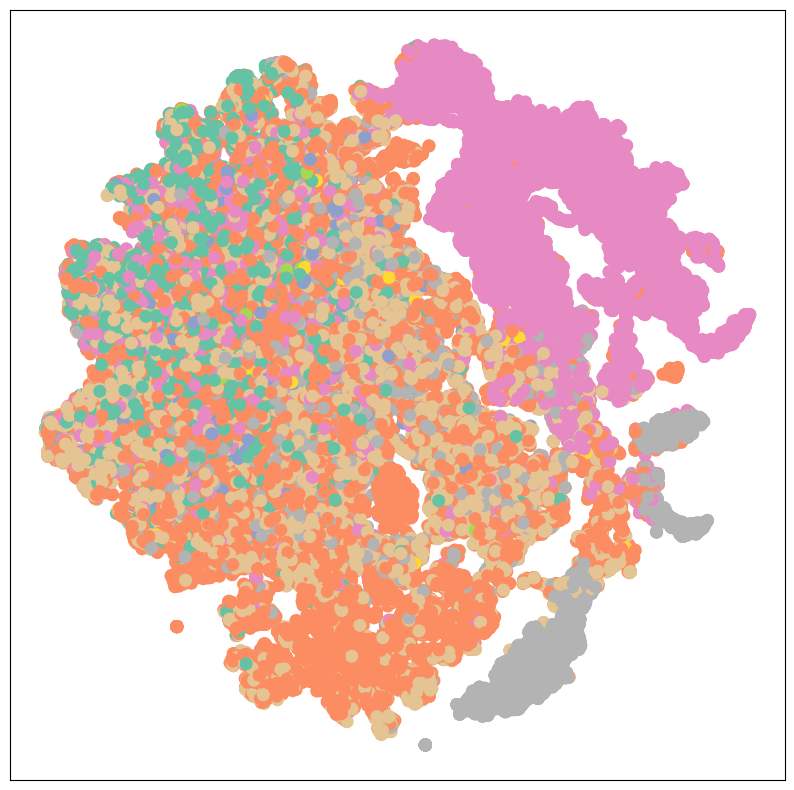

In [ ]:
visualize(node_embedding,node_types)

In [7]:
node_embedding = pd.read_csv('/home/mayank/view4_dismult_node_embeddings.csv', header = None)

In [8]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,"('<http://www.ncbi.nlm.nih.gov/gene/1163>', 'G...",-0.089618,-0.095461,0.080421,0.094052,0.089214,-0.091372,-0.091172,-0.092466,-0.075546,...,-0.093747,-0.087219,0.091069,-0.091236,-0.092616,-0.090954,-0.094112,0.080748,0.091031,-0.080862
1,('<http://purl.obolibrary.org/obo/GO_1902115>'...,-0.082664,-0.109624,-0.156363,0.091936,0.076778,-0.047295,-0.055982,-0.051836,0.157801,...,-0.080951,-0.048818,0.064087,-0.067977,-0.077373,-0.036197,-0.097142,-0.159332,0.070650,0.165940
2,('<http://purl.obolibrary.org/obo/MONDO_000930...,-0.013673,-0.025345,0.056345,0.002595,0.003591,-0.004411,-0.003023,-0.000463,-0.066021,...,-0.010451,-0.003690,0.002681,-0.003008,-0.005872,-0.008985,-0.012677,0.064492,0.008009,-0.060671
3,"('<http://www.ncbi.nlm.nih.gov/gene/2692>', 'G...",-0.120501,-0.118544,0.035302,0.120110,0.126195,-0.123091,-0.121702,-0.121613,-0.028086,...,-0.119881,-0.121501,0.120557,-0.119379,-0.123636,-0.125616,-0.119734,0.034028,0.124483,-0.036041
4,('<http://purl.obolibrary.org/obo/MONDO_000053...,0.049586,0.095184,0.103703,-0.059606,-0.055049,0.051761,0.055281,0.061162,-0.107084,...,0.054232,0.057338,-0.055032,0.058805,0.054063,0.062727,0.064729,0.102270,-0.055428,-0.099102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85294,('<http://purl.obolibrary.org/obo/UBERON_00351...,0.028779,0.027108,-0.055930,-0.033921,-0.022444,0.034148,0.029866,0.024569,0.056606,...,0.027949,0.029385,-0.031496,0.035526,0.022900,0.032367,0.029598,-0.056074,-0.035319,0.054529
85295,('<https://www.mirbase.org/mature/MIMAT0002841...,0.212186,0.232590,0.189135,-0.218036,-0.189510,0.196684,0.202743,0.213414,-0.200198,...,0.209227,0.203518,-0.199239,0.194354,0.211170,0.192850,0.215593,0.195103,-0.208386,-0.215768
85296,('<http://purl.obolibrary.org/obo/CHEBI_36834>...,0.078071,0.062487,-0.094024,-0.063701,-0.091921,0.082022,0.081439,0.087534,0.103762,...,0.066663,0.083494,-0.087882,0.079296,0.085562,0.094192,0.090808,-0.095603,-0.084249,0.095795
85297,('<http://purl.obolibrary.org/obo/HP_0500107>'...,-0.023919,0.047597,0.023836,0.030392,0.027456,-0.034135,-0.026621,-0.027454,-0.021332,...,-0.026396,-0.032480,0.026624,-0.022232,-0.023161,-0.030786,-0.024137,0.023944,0.026593,-0.024358


In [9]:
node_embedding.set_index(node_embedding.columns[0], inplace=True)

In [10]:
node_embedding.values

array([[-0.08961756, -0.09546144,  0.08042074, ...,  0.0807479 ,
         0.09103095, -0.08086184],
       [-0.08266386, -0.10962405, -0.15636304, ..., -0.15933186,
         0.07064981,  0.16594003],
       [-0.01367345, -0.02534487,  0.05634483, ...,  0.06449161,
         0.00800858, -0.06067073],
       ...,
       [ 0.07807113,  0.06248745, -0.09402434, ..., -0.0956027 ,
        -0.08424941,  0.09579546],
       [-0.02391861,  0.04759688,  0.02383566, ...,  0.02394448,
         0.02659339, -0.02435761],
       [-0.11407271, -0.11618926,  0.11599927, ...,  0.11541972,
         0.10947888, -0.11119961]])

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

/tmp/ipykernel_332451/1780641566.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


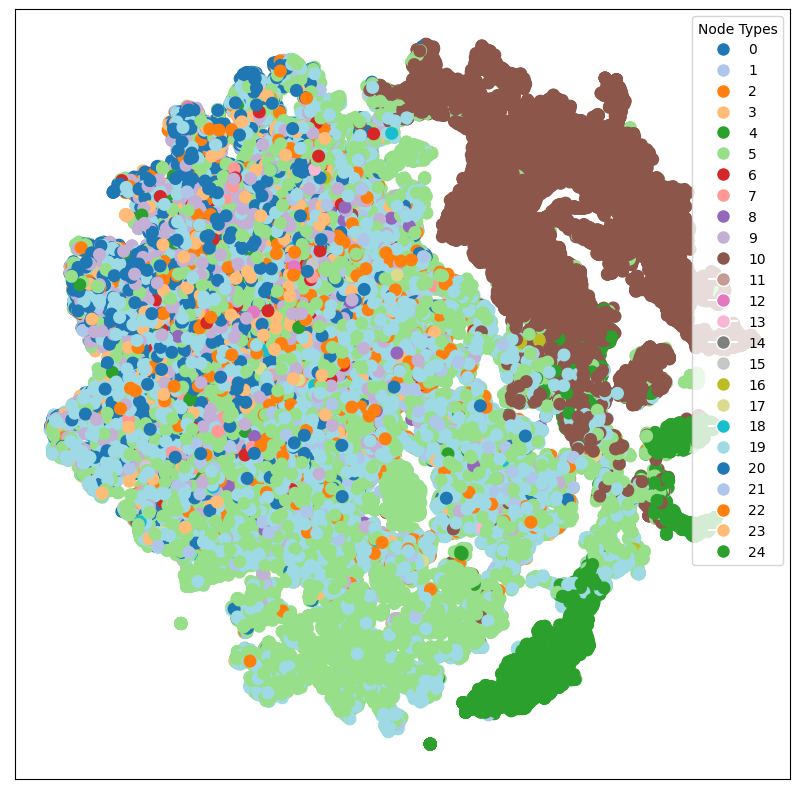

In [24]:
visualize(node_embedding.values,node_types)

In [ ]:
nodes_df

,name,type
0,<http://www.ncbi.nlm.nih.gov/gene/1163>,Gene
1,<http://purl.obolibrary.org/obo/GO_1902115>,GO
2,<http://purl.obolibrary.org/obo/MONDO_0009301>,Disease
3,<http://www.ncbi.nlm.nih.gov/gene/2692>,Gene
4,<http://purl.obolibrary.org/obo/MONDO_0000535>,Disease
...,...,...
85294,<http://purl.obolibrary.org/obo/UBERON_0035110>,Anatomy
85295,<https://www.mirbase.org/mature/MIMAT0002841>,miRNA
85296,<http://purl.obolibrary.org/obo/CHEBI_36834>,Chemical
85297,<http://purl.obolibrary.org/obo/HP_0500107>,Phenotype


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embedding.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.6499
Precision: 0.6446
Recall: 0.6499


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

selected_classes = ['miRNA', 'Gene', 'Disease']

filtered_embeddings = []
filtered_labels = []


for class_label in selected_classes:

    class_indices = nodes_df[nodes_df['type'] == class_label].index


    class_embeddings = node_embedding.iloc[class_indices, 1:].values  # Skip the first column with identifiers

    # Append the filtered embeddings and labels
    filtered_embeddings.append(class_embeddings)
    filtered_labels.extend([class_label] * len(class_embeddings))


X_filtered = np.vstack(filtered_embeddings)

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(filtered_labels)  # Convert the labels into numerical form


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

precision_per_class = precision_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))
recall_per_class = recall_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))

for i, class_label in enumerate(le.classes_):
    if class_label in selected_classes:
        print(f"Class: {class_label}")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")


Accuracy: 0.9749
Precision: 0.9749
Recall: 0.9749
Class: Disease
  Precision: 0.9817
  Recall: 0.9838
Class: Gene
  Precision: 0.9676
  Recall: 0.9792
Class: miRNA
  Precision: 0.9691
  Recall: 0.9158


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the labels
true_labels = nodes_df['type']
X =  node_embedding.values

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(true_labels)  # Convert the labels into numerical form

class_distribution = np.bincount(y)
print("Class distribution:", dict(zip(le.classes_, class_distribution)))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42,  class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

for i, class_label in enumerate(le.classes_):
    try:
        precision_class = precision_score(y_test, y_pred, labels=[i], average='macro')
        recall_class = recall_score(y_test, y_pred, labels=[i], average='macro')
        f1_class = f1_score(y_test, y_pred, labels=[i], average='macro')
        print(f"Class: {class_label}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
    except IndexError:
        print(f"Class: {class_label}")
        print("  Precision: 0.0000 (No predictions for this class)")
        print("  Recall: 0.0000")
        print("  F1 Score: 0.0000")

Class distribution: {'Anatomy': 6129, 'Basic formal': 1, 'Cell': 1272, 'Chemical': 2000, 'Chromosome': 310, 'Disease': 23966, 'Environment': 446, 'Environmental exposure': 419, 'Food': 172, 'GO': 4071, 'Gene': 18341, 'General medical science': 6, 'Human developmental stage': 72, 'Medical action': 114, 'Mental disease': 12, 'Mental functioning': 14, 'Mouse pathology': 75, 'NCI thesaurus': 84, 'Neuro behaviour': 153, 'Phenotype': 18488, 'Protein': 205, 'Sequence': 2386, 'Species': 1766, 'Vaccine': 1, 'miRNA': 4796}


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packag

Overall Accuracy: 0.6387
Class: Anatomy
  Precision: 0.3385
  Recall: 0.4193
  F1 Score: 0.3746
Class: Basic formal
  Precision: 0.8333
  Recall: 0.0262
  F1 Score: 0.0509
Class: Cell
  Precision: 0.4800
  Recall: 0.0413
  F1 Score: 0.0761
Class: Chemical
  Precision: 0.9623
  Recall: 0.5000
  F1 Score: 0.6581
Class: Chromosome
  Precision: 0.6079
  Recall: 0.7518
  F1 Score: 0.6722
Class: Disease
  Precision: 1.0000
  Recall: 0.0081
  F1 Score: 0.0161
Class: Environment
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Environmental exposure
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Food
  Precision: 0.4010
  Recall: 0.1311
  F1 Score: 0.1976
Class: GO
  Precision: 0.9475
  Recall: 0.9789
  F1 Score: 0.9630
Class: Gene
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: General medical science
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Human developmental stage
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packag

Class: Medical action
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mental disease
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mental functioning
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mouse pathology
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: NCI thesaurus
  Precision: 0.4715
  Recall: 0.5762
  F1 Score: 0.5186
Class: Neuro behaviour
  Precision: 0.8750
  Recall: 0.1094
  F1 Score: 0.1944
Class: Phenotype
  Precision: 0.7273
  Recall: 0.0118
  F1 Score: 0.0232


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packag

Class: Protein
  Precision: 0.2222
  Recall: 0.0038
  F1 Score: 0.0074
Class: Sequence
  Precision: 0.9727
  Recall: 0.9127
  F1 Score: 0.9417
Class: Species
Class: Species
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000
Class: Vaccine
Class: Vaccine
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000
Class: miRNA
Class: miRNA
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
node_embeddings = pd.read_csv('/content/drive/MyDrive/models_thesis/mayank/view4_dismult_node_embeddings.csv', header= None)

In [17]:
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,"('<http://www.ncbi.nlm.nih.gov/gene/1163>', 'G...",-0.089618,-0.095461,0.080421,0.094052,0.089214,-0.091372,-0.091172,-0.092466,-0.075546,...,-0.093747,-0.087219,0.091069,-0.091236,-0.092616,-0.090954,-0.094112,0.080748,0.091031,-0.080862
1,('<http://purl.obolibrary.org/obo/GO_1902115>'...,-0.082664,-0.109624,-0.156363,0.091936,0.076778,-0.047295,-0.055982,-0.051836,0.157801,...,-0.080951,-0.048818,0.064087,-0.067977,-0.077373,-0.036197,-0.097142,-0.159332,0.070650,0.165940
2,('<http://purl.obolibrary.org/obo/MONDO_000930...,-0.013673,-0.025345,0.056345,0.002595,0.003591,-0.004411,-0.003023,-0.000463,-0.066021,...,-0.010451,-0.003690,0.002681,-0.003008,-0.005872,-0.008985,-0.012677,0.064492,0.008009,-0.060671
3,"('<http://www.ncbi.nlm.nih.gov/gene/2692>', 'G...",-0.120501,-0.118544,0.035302,0.120110,0.126195,-0.123091,-0.121702,-0.121613,-0.028086,...,-0.119881,-0.121501,0.120557,-0.119379,-0.123636,-0.125616,-0.119734,0.034028,0.124483,-0.036041
4,('<http://purl.obolibrary.org/obo/MONDO_000053...,0.049586,0.095184,0.103703,-0.059606,-0.055049,0.051761,0.055281,0.061162,-0.107084,...,0.054232,0.057338,-0.055032,0.058805,0.054063,0.062727,0.064729,0.102270,-0.055428,-0.099102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85294,('<http://purl.obolibrary.org/obo/UBERON_00351...,0.028779,0.027108,-0.055930,-0.033921,-0.022444,0.034148,0.029866,0.024569,0.056606,...,0.027949,0.029385,-0.031496,0.035526,0.022900,0.032367,0.029598,-0.056074,-0.035319,0.054529
85295,('<https://www.mirbase.org/mature/MIMAT0002841...,0.212186,0.232590,0.189135,-0.218036,-0.189510,0.196684,0.202743,0.213414,-0.200198,...,0.209227,0.203518,-0.199239,0.194354,0.211170,0.192850,0.215593,0.195103,-0.208386,-0.215768
85296,('<http://purl.obolibrary.org/obo/CHEBI_36834>...,0.078071,0.062487,-0.094024,-0.063701,-0.091921,0.082022,0.081439,0.087534,0.103762,...,0.066663,0.083494,-0.087882,0.079296,0.085562,0.094192,0.090808,-0.095603,-0.084249,0.095795
85297,('<http://purl.obolibrary.org/obo/HP_0500107>'...,-0.023919,0.047597,0.023836,0.030392,0.027456,-0.034135,-0.026621,-0.027454,-0.021332,...,-0.026396,-0.032480,0.026624,-0.022232,-0.023161,-0.030786,-0.024137,0.023944,0.026593,-0.024358


In [18]:
node_embeddings.set_index(node_embeddings.columns[0], inplace=True)

In [19]:
node_embeddings.values

array([[-0.08961756, -0.09546144,  0.08042074, ...,  0.0807479 ,
         0.09103095, -0.08086184],
       [-0.08266386, -0.10962405, -0.15636304, ..., -0.15933186,
         0.07064981,  0.16594003],
       [-0.01367345, -0.02534487,  0.05634483, ...,  0.06449161,
         0.00800858, -0.06067073],
       ...,
       [ 0.07807113,  0.06248745, -0.09402434, ..., -0.0956027 ,
        -0.08424941,  0.09579546],
       [-0.02391861,  0.04759688,  0.02383566, ...,  0.02394448,
         0.02659339, -0.02435761],
       [-0.11407271, -0.11618926,  0.11599927, ...,  0.11541972,
         0.10947888, -0.11119961]])

In [11]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [12]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [31]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embedding.index = [name[0] for name in node_embedding.index]

In [33]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embedding.values,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)

Evaluating on VIEW4_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

In [34]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINEv4dis.csv"
results.to_csv(filename)

In [35]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,matthews_correlation_coefficient,prevalence_threshold,false_omission_rate,accuracy,fall_out,informedness,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.244054,0.478028,0.160497,0.577684,0.807908,0.155368,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.246972,0.477874,0.154730,0.578312,0.808280,0.156625,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.237849,0.478578,0.169286,0.575737,0.809757,0.151474,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.241733,0.478353,0.161945,0.576632,0.810026,0.153264,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.237877,0.478526,0.170007,0.575880,0.809148,0.151760,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.244182,0.478010,0.160414,0.577741,0.807794,0.155483,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.235476,0.478839,0.171878,0.574856,0.811076,0.149712,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.238054,0.478736,0.166259,0.575321,0.811836,0.150641,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.232020,0.479167,0.176427,0.573711,0.812388,0.147422,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.236657,0.478835,0.168634,0.574951,0.811954,0.149903,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


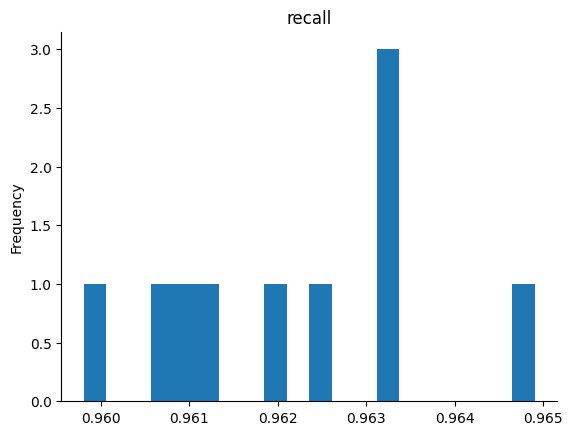

In [36]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

In [15]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features= node_embedding.values,  # Use simplified embedding features
    smoke_test=False
)

Evaluating on VIEW4_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

In [16]:
results = evaluation
filename = "results_"+view_name+"DesicionTree_V4distmult.csv"
results.to_csv(filename)

In [17]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,f1_score,negative_predictive_value,threat_score,matthews_correlation_coefficient,positive_likelyhood_ratio,precision,...,"(model_parameters, criterion)","(model_parameters, splitter)","(model_parameters, max_depth)","(model_parameters, min_samples_split)","(model_parameters, min_samples_leaf)","(model_parameters, min_weight_fraction_leaf)","(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, ccp_alpha)"
0,train,0.800001,1.0,True,0.692940,0.823280,0.530152,0.234309,1.185583,0.542456,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.694023,0.831967,0.531421,0.238905,1.188102,0.542983,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.668384,0.674155,0.501935,0.148794,1.135754,0.531781,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.666825,0.667349,0.500178,0.143845,1.131788,0.530910,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.676737,0.713946,0.511415,0.175762,1.155629,0.536098,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.675705,0.708625,0.510238,0.172422,1.153434,0.535625,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.664910,0.655661,0.498026,0.109941,1.080787,0.519413,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.664998,0.656151,0.498125,0.109936,1.080515,0.519350,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.693837,0.824716,0.531203,0.238372,1.191766,0.543747,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.695202,0.835263,0.532804,0.244120,1.195094,0.544439,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0


In [18]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)

  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.676793   0.534699  0.931564  0.679362  0.560442
1            Test  0.716074   0.534661  0.931674  0.679351  0.560412
